In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
import seaborn as sns
import warnings
from scipy.stats import entropy
from sklearn.cluster import DBSCAN

warnings.filterwarnings("ignore")
import os
import glob


def getDF(df_raw, featurename):
    #columnname = [featurename]
    #df_extract = df_raw.loc[:, columnname].copy()
    df_extract = df_raw.copy()

    #if 'Time' in df_raw.columns:
    #    df_extract.index = pd.to_datetime(df_raw["Time"],
    #                                      format='%Y-%m-%d %H:%M:%S')
    if 'date' in df_raw.columns:
        df_extract.index = pd.to_datetime(df_raw["date"], format='%Y-%m-%d')


    # Transfer datetime
    #     from datetime import datetime

    df_extract['DoW'] = [''] * len(df_extract)
    df_extract['Month'] = [''] * len(df_extract)
    df_extract['Date'] = [''] * len(df_extract)
    df_extract['Hour'] = [''] * len(df_extract)
    df_extract['Week'] = [''] * len(df_extract)
    df_extract['Minute'] = [''] * len(df_extract)

    for i,(indx, eachrow) in enumerate(df_extract.iterrows()):
        if i%50 == 0:
            print(i)
        df_extract['DoW'].loc[indx] = (indx.strftime('%A'))
        df_extract['Month'].loc[indx] = int(indx.month)
        df_extract['Date'].loc[indx] = (indx.strftime("%Y/%m/%d"))
        df_extract['Hour'].loc[indx] = int(indx.strftime("%H"))
        df_extract['Minute'].loc[indx] = int(indx.strftime("%M"))
        df_extract['Week'].loc[indx] = int(indx.strftime('%W'))
    return df_extract


def getDF_bymonth(df_raw, featurename, month):
    columnname = [featurename]
    df_extract = df_raw.loc[:, columnname].copy()
    if 'Time' in df_raw.columns:
        df_extract.index = pd.to_datetime(df_raw["Time"],
                                          format='%Y-%m-%d %H:%M:%S')

    # Transfer datetime
    #     from datetime import datetime

    df_extract['DoW'] = [''] * len(df_extract)
    df_extract['Month'] = [''] * len(df_extract)
    df_extract['Date'] = [''] * len(df_extract)
    df_extract['Hour'] = [''] * len(df_extract)
    df_extract['Week'] = [''] * len(df_extract)
    df_extract['Minute'] = [''] * len(df_extract)
    for indx, eachrow in df_extract.iterrows():
        df_extract['DoW'].loc[indx] = (indx.strftime('%A'))
        df_extract['Month'].loc[indx] = int(indx.month)
        df_extract['Date'].loc[indx] = (indx.strftime("%Y/%m/%d"))
        df_extract['Hour'].loc[indx] = int(indx.strftime("%H"))
        df_extract['Minute'].loc[indx] = int(indx.strftime("%M"))
        df_extract['Week'].loc[indx] = int(indx.strftime('%U'))
    df_monthsplit_extract = df_extract.loc[df_extract['Month'] == month]
    return df_monthsplit_extract

# Compute timeseries statistics and plot for individual patients

In [48]:
path = r''  # Specify data path

extension = 'csv'

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]

patient_unstrip_IDs = [i.split('_entries', 1)[0] for i in files]

patient_IDs = [ele.lstrip('0') for ele in patient_unstrip_IDs]

df_id_files = pd.DataFrame({'id': patient_IDs, 'EntriesFileName': files})

i = 0

for f in files:
    
    p = os.path.join(path, f)

    print("Patient ID: ", int(df_id_files.id[i]))

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")
    df.index = pd.to_datetime(df["Timestamp"], format='%Y-%m-%d %H:%M:%S')

    df = df[~df.index.duplicated(keep='first')]  #remove duplicate indexes
    df = df[df['glucose'] > 39]  # remove everything less than 39
    df = df[df['glucose'] < 1000]  # remove everything greater than 40
    df['glucose'].values[
        df['glucose'] >
        400] = 400  # anything greater than 400 replace with 400

    df['Dateonly'] = df["Date"].str.split("/", n=2, expand=True)[2].astype(int)

    ## Plots and statistics

    print(df[["glucose", "DoW"]].groupby("DoW").describe())

    # make boxplot with Catplot
    a = sns.catplot(x='DoW',
                    y='glucose',
                    kind="box",
                    data=df,
                    height=4,
                    aspect=18.7 / 8.27,
                    order=('Monday', 'Tuesday', 'Wednesday', 'Thursday',
                           'Friday', 'Saturday', 'Sunday'))

    # add data points to boxplot with stripplot
    a = sns.stripplot(x='DoW',
                      y='glucose',
                      data=df,
                      alpha=0.2,
                      jitter=0.02,
                      color='#F36B4D',
                      order=('Monday', 'Tuesday', 'Wednesday', 'Thursday',
                             'Friday', 'Saturday', 'Sunday'))

    a.set(xlabel="Day", ylabel="Glucose (mg/dL)")

    plt.show()

    print(df[["glucose", "Hour"]].groupby("Hour").describe())

    # make boxplot with Catplot
    b = sns.catplot(x='Hour',
                    y='glucose',
                    kind="box",
                    data=df,
                    height=4,
                    aspect=25.7 / 8.27)

    # add data points to boxplot with stripplot
    b = sns.stripplot(x='Hour',
                      y='glucose',
                      data=df,
                      alpha=0.2,
                      jitter=0.02,
                      color='#F36B4D')
    b.set(xlabel="Hour", ylabel="Glucose (mg/dL)")

    plt.show()

    print(df[["glucose", "Month"]].groupby("Month").describe())

    # make boxplot with Catplot
    c = sns.catplot(x='Month',
                    y='glucose',
                    kind="box",
                    data=df,
                    height=4,
                    aspect=18.7 / 8.27)

    # add data points to boxplot with stripplot
    c = sns.stripplot(x='Month',
                      y='glucose',
                      data=df,
                      alpha=0.2,
                      jitter=0.02,
                      color='#F36B4D')

    c.set(xlabel="Month", ylabel="Glucose (mg/dL)")

    plt.show()

    print(df[["glucose", "Dateonly"]].groupby("Dateonly").describe())

    # make boxplot with Catplot
    d = sns.catplot(x='Dateonly',
                    y='glucose',
                    kind="box",
                    data=df,
                    height=4,
                    aspect=25.7 / 8.27)

    # add data points to boxplot with stripplot
    d = sns.stripplot(x='Dateonly',
                      y='glucose',
                      data=df,
                      alpha=0.2,
                      jitter=0.02,
                      color='#F36B4D')

    d.set(xlabel="Date of Month", ylabel="Glucose (mg/dL)")

    plt.show()
    print('=======' * 20)
    print('=======' * 20)

    i = i + 1

FileNotFoundError: [Errno 2] No such file or directory: ''

In [4]:
dir_ = "/home/reinhold/Daten/Paper_Datasets_Nov2022"
filenames = [r'OpenAPS complete_patient_statistics.xlsx',
    r'OPENonOH complete_patient_statistics.xlsx'] # Specify the file path

df_all_stat = {}
df_all_stat["OpenAPS"] = pd.read_excel(os.path.join(dir_, filenames[0]))  # all columns
df_all_stat["OPENonOH"] = pd.read_excel(os.path.join(dir_, filenames[1]))
print(len(df_all_stat["OPENonOH"].loc[df_all_stat["OPENonOH"]["id"].isna()]), df_all_stat["OPENonOH"].loc[df_all_stat["OPENonOH"]["id"].isna()])
df_all_stat["OpenAPS"]["id"] = df_all_stat["OpenAPS"]["id"].astype(int)
df_all_stat["OPENonOH"]["id"] = df_all_stat["OPENonOH"]["id"].astype(int)
print(len(df_all_stat["OPENonOH"].columns), df_all_stat["OPENonOH"].columns)


0 Empty DataFrame
Columns: [id, age, gender, height, weight, country, year, month, interdaysd, interdaycv, bg_roc_stds, TOR<70, TIR, TOR>180, POR, J_index, LGBI, HBGI, GMI, count, mean, std, min, 0.25, 0.5, 0.75, max]
Index: []

[0 rows x 27 columns]
27 Index([         'id',         'age',      'gender',      'height',
            'weight',     'country',        'year',       'month',
        'interdaysd',  'interdaycv', 'bg_roc_stds',      'TOR<70',
               'TIR',     'TOR>180',         'POR',     'J_index',
              'LGBI',        'HBGI',         'GMI',       'count',
              'mean',         'std',         'min',          0.25,
                 0.5,          0.75,         'max'],
      dtype='object')


In [83]:
root_dir = "/home/reinhold/Daten/dana_processing/"
sub_dir =['OpenAPS_NS_Data', 'OpenAPS_AAPS_Uploader_Data', 'OPENonOH_NS_Data', 'OPENonOH_AAPS_Uploader_Data']
filenames_per_day = ['OpenAPS_NS_per_day.csv', 'OpenAPS_AAPS_Uploader_per_day.csv', 'OPENonOH_NS_per_day.csv', 'OPENonOH_AAPS_Uploader_per_day.csv']

df_per_day = {}
df1 = []
for i in range(len(sub_dir)):
    df1.append(pd.read_csv(os.path.join(root_dir, sub_dir[i], filenames_per_day[i])))
df_per_day["OpenAPS"] = pd.concat([df1[0], df1[1]], axis=0)
df_per_day["OPENonOH"] = pd.concat([df1[2], df1[3]], axis=0)
df_per_day["OpenAPS"]["pm_id"] = df_per_day["OpenAPS"]["pm_id"].astype(int)
df_per_day["OPENonOH"]["pm_id"] = df_per_day["OPENonOH"]["pm_id"].astype(int)
print(len(df_per_day["OPENonOH"].columns), df_per_day["OPENonOH"].columns)

9 Index(['Unnamed: 0', 'date', 'sgv_mean', 'sgv_std', 'sgv_min', 'sgv_max',
       'sgv_count', 'filename', 'pm_id'],
      dtype='object')


# join the statistics and the per day data

In [84]:
df = {}
df["OpenAPS"] = pd.merge(df_all_stat["OpenAPS"], df_per_day["OpenAPS"], left_on='id', right_on='pm_id', how='inner')
df["OPENonOH"] = pd.merge(df_all_stat["OPENonOH"], df_per_day["OPENonOH"], left_on='id', right_on='pm_id', how='inner')

print(df_per_day["OpenAPS"]["pm_id"].unique().shape, df_per_day["OPENonOH"]["pm_id"].unique().shape)
print(df_all_stat["OpenAPS"]["id"].unique().shape, df_all_stat["OPENonOH"]["id"].unique().shape)
print(df["OpenAPS"]["id"].unique().shape, df["OPENonOH"]["id"].unique().shape)
print(df["OpenAPS"]["id"].shape, df["OPENonOH"]["id"].shape)

print(set(df_all_stat["OPENonOH"]["id"].tolist()) - set(df["OPENonOH"]["id"].tolist()))
#print(df_all_stat["OPENonOH"].loc[ not in df["OPENonOH"]["id"].tolist(),"id"])
#print(df["OpenAPS"].loc[df["OpenAPS"]["id"] not in df_all_stat["OpenAPS"]["id"].values, "id"].unique(), df_all_stat["OpenAPS"]["id"])


(130,) (95,)
(122,) (75,)
(83,) (74,)
(25312,) (37650,)
{46968717}


In [85]:
print(df["OPENonOH"].columns)
df2 = df["OPENonOH"][["id", "gender", "sgv_mean", "sgv_std", "filename", "date"]]
df2["DoW"] = df2["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").weekday())
df2["DoW_str"] = df2["DoW"].apply(lambda x: "monday" if x == 0 else "tuesday" if x == 1 else "wednesday" if x == 2 else "thursday" if x == 3 else "friday" if x == 4 else "saturday" if x == 5 else "sunday")
df2["year"] = df2["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").year)
df2["month"] = df2["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").month)
df2["day"] = df2["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").day)
print(df2)
from pandasgui import show
#show(df2)


Index([         'id',         'age',      'gender',      'height',
            'weight',     'country',        'year',       'month',
        'interdaysd',  'interdaycv', 'bg_roc_stds',      'TOR<70',
               'TIR',     'TOR>180',         'POR',     'J_index',
              'LGBI',        'HBGI',         'GMI',       'count',
              'mean',         'std',         'min',          0.25,
                 0.5,          0.75,         'max',  'Unnamed: 0',
              'date',    'sgv_mean',     'sgv_std',     'sgv_min',
           'sgv_max',   'sgv_count',    'filename',       'pm_id'],
      dtype='object')
             id  gender    sgv_mean    sgv_std  \
0      27718918  Female  162.756944  43.509981   
1      27718918  Female  145.211806  45.645280   
2      27718918  Female  146.975694  45.826701   
3      27718918  Female  137.920139  38.254747   
4      27718918  Female  154.399306  58.836604   
...         ...     ...         ...        ...   
37645   2843395    Male 

2014 2022


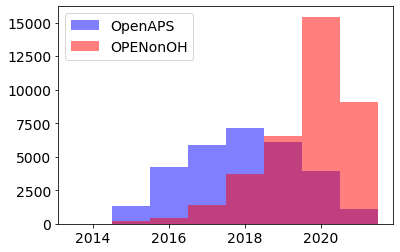

In [86]:
df10 = df_per_day["OpenAPS"]
df10["year"] = df10["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").year)

min_, max_ = min(df2["year"].min(),df10["year"].min()), max(df2["year"].max(),df10["year"].max())
print(min_, max_)
counts_OpenAPS, bins_OpenAPS = np.histogram(df10["year"], bins=[min_ - 0.5, max_ + 0.5])
counts_OPENonOH, bins_OPENonOH = np.histogram(df2["year"], bins=[min_ - 0.5, max_ + 0.5])
#min_, max_ = df10["year"].min(), df10["year"].max()
plt.hist(df10["year"], bins=np.arange(min_ -0.5, max_ + 0.5), color="blue", label="OpenAPS", alpha=0.5)
#min_, max_ = df2["year"].min(), df2["year"].max()
plt.hist(df2["year"], bins=np.arange(min_ -0.5, max_ + 0.5), color="red", label="OPENonOH", alpha=0.5)

plt.legend()
#plt.stairs(counts_OPENonOH, bins=bins_OPENonOH, color="red", label="OPENonOH")

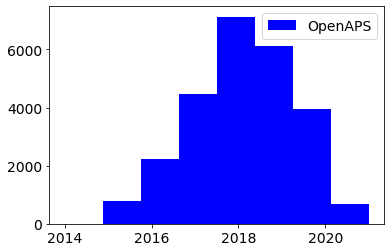

In [79]:
min_, max_ = df10["year"].min(), df10["year"].max()
plt.hist(df10["year"], bins=max_ - min_ + 1, color="blue", label="OpenAPS")
plt.legend()


In [42]:
def df_groupedby(df, gender = "Male", var = "DoW"):
    df_grby = df.loc[df["gender"] == gender, :].groupby(by=var).mean()
    df_grby[var] = df_grby.index
    if var == "DoW": 
        df_grby["DoW_str"] = df_grby["DoW"].apply(lambda x: "monday" if x == 0 else "tuesday" if x == 1 else "wednesday" if x == 2 else "thursday" if x == 3 else "friday" if x == 4 else "saturday" if x == 5 else "sunday")
    return df_grby


In [43]:

df3 = {}
for var in ["DoW", "month", "day"]:
    df3[var] = {}
    for gender in ["Female", "Male"]:
        df3[var][gender] = df_groupedby(df2, gender, var)
print(df3)

{'DoW': {'Female':                id    sgv_mean    sgv_std     month        day  DoW    DoW_str
DoW                                                                          
0    3.455589e+07  125.622601  35.922883  6.764560  15.631351    0     monday
1    3.430411e+07  125.852534  36.668636  6.773691  15.602868    1    tuesday
2    3.417928e+07  127.062324  37.135209  6.749066  15.525529    2  wednesday
3    3.431502e+07  126.090102  36.495051  6.774053  15.757294    3   thursday
4    3.438203e+07  125.694095  37.074211  6.718108  15.784070    4     friday
5    3.443197e+07  125.460006  37.382918  6.714642  15.780685    5   saturday
6    3.472173e+07  127.108742  37.409857  6.739641  15.627087    6     sunday, 'Male':                id    sgv_mean    sgv_std     month        day  DoW    DoW_str
DoW                                                                          
0    3.487988e+07  133.513419  34.138429  6.657211  15.807264    0     monday
1    3.479894e+07  131.727704  33.24

# Average statistics using timeseries breakdown on daily basis and classification based on gender

In [13]:
path = r'OpenAPS_AAPS_Uploader_per_day.csv'  # specify data path
demographics_path = r''  # specify data path

df_demographics = pd.read_csv(demographics_path, index_col=None)

extension = 'csv'

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]

patient_unstrip_IDs = [i.split('_entries', 1)[0] for i in files]

patient_IDs = [ele.lstrip('0') for ele in patient_unstrip_IDs]

df_id_files = pd.DataFrame({'id': patient_IDs, 'EntriesFileName': files})

i = 0

Monday = []
Tuesday = []
Wednesday = []
Thursday = []
Friday = []
Saturday = []
Sunday = []
demographics = []

i = 0

for f in files:

    patient_demographic = df_demographics[(df_demographics['id'] == int(
        df_id_files.id[i]))]

    if not patient_demographic.empty:
        demographics.append(patient_demographic)

        p = os.path.join(path, f)

        print("Patient ID: ", int(df_id_files.id[i]))

        # reading and processing files
        df = pd.read_csv(p, index_col=None, na_values=" null")
        df.index = pd.to_datetime(df["Timestamp"], format='%Y-%m-%d %H:%M:%S')

        df = df[~df.index.duplicated(keep='first')]  #remove duplicate indexes
        df = df[df['glucose'] > 39]  # remove everything less than 39
        df = df[df['glucose'] < 1000]  # remove everything greater than 40
        df['glucose'].values[
            df['glucose'] >
            400] = 400  # anything greater than 400 replace with 400

        df['Dateonly'] = df["Date"].str.split("/", n=2,
                                              expand=True)[2].astype(int)

        ## statistics
        Monday.append(
            pd.DataFrame(df['glucose'].loc[df['DoW'] ==
                                           'Monday']).describe().transpose())
        Tuesday.append(
            pd.DataFrame(df['glucose'].loc[df['DoW'] ==
                                           'Tuesday']).describe().transpose())
        Wednesday.append(
            pd.DataFrame(df['glucose'].loc[
                df['DoW'] == 'Wednesday']).describe().transpose())
        Thursday.append(
            pd.DataFrame(df['glucose'].loc[df['DoW'] ==
                                           'Thursday']).describe().transpose())
        Friday.append(
            pd.DataFrame(df['glucose'].loc[df['DoW'] ==
                                           'Friday']).describe().transpose())
        Saturday.append(
            pd.DataFrame(df['glucose'].loc[df['DoW'] ==
                                           'Saturday']).describe().transpose())
        Sunday.append(
            pd.DataFrame(df['glucose'].loc[df['DoW'] ==
                                           'Sunday']).describe().transpose())

    i = i + 1

Patient ID:  221634
Patient ID:  309157
Patient ID:  897741
Patient ID:  2033176
Patient ID:  2199852
Patient ID:  4762925
Patient ID:  7886752
Patient ID:  12689381
Patient ID:  13029224
Patient ID:  13484299
Patient ID:  14092221
Patient ID:  15558575
Patient ID:  15634563
Patient ID:  16975609
Patient ID:  17161370
Patient ID:  18991425
Patient ID:  19626656
Patient ID:  20216809
Patient ID:  20396154
Patient ID:  20649783
Patient ID:  21946407
Patient ID:  23428091
Patient ID:  24448124
Patient ID:  25692073
Patient ID:  26856617
Patient ID:  27526291
Patient ID:  27819368
Patient ID:  28176124
Patient ID:  28608066
Patient ID:  28756888
Patient ID:  28768536
Patient ID:  32407882
Patient ID:  32997134
Patient ID:  33962890
Patient ID:  35533061
Patient ID:  35719805
Patient ID:  37764532
Patient ID:  37948668
Patient ID:  37998755
Patient ID:  39986716
Patient ID:  40634871
Patient ID:  41131654
Patient ID:  42052178
Patient ID:  43589707
Patient ID:  45120081
Patient ID:  4732353

In [16]:
monday = pd.concat(Monday)  # convert statistics to dataframe
monday.reset_index(drop=True, inplace=True)
tuesday = pd.concat(Tuesday)
tuesday.reset_index(drop=True, inplace=True)
wednesday = pd.concat(Wednesday)
wednesday.reset_index(drop=True, inplace=True)
thursday = pd.concat(Thursday)
thursday.reset_index(drop=True, inplace=True)
friday = pd.concat(Friday)
friday.reset_index(drop=True, inplace=True)
saturday = pd.concat(Saturday)
saturday.reset_index(drop=True, inplace=True)
sunday = pd.concat(Sunday)
sunday.reset_index(drop=True, inplace=True)

all_stats3 = pd.concat(demographics)
all_stats3.reset_index(drop=True, inplace=True)
all_stats3 = all_stats3.drop(all_stats3.tail(7).index)
all_stats3 = all_stats3.filter(
    ['id', 'height', 'weight', 'age', 'gender', 'country', 'DIYTech'], axis=1)

monday_statistics = pd.concat([all_stats3, monday], axis=1)
tuesday_statistics = pd.concat([all_stats3, tuesday], axis=1)
wednesday_statistics = pd.concat([all_stats3, wednesday], axis=1)
thursday_statistics = pd.concat([all_stats3, thursday], axis=1)
friday_statistics = pd.concat([all_stats3, friday], axis=1)
saturday_statistics = pd.concat([all_stats3, saturday], axis=1)
sunday_statistics = pd.concat([all_stats3, sunday], axis=1)

## Save daily output statistics for male and females

In [14]:
result = r'' # specify data path
    
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:,.2f}".format

monday_stats_m = monday_statistics[(monday_statistics['gender'] == 'Male')]
monday_stats_m.reset_index(drop=True)
monday_stats_m.to_csv(os.path.join(result, "monday_stats_m.csv"))

monday_stats_f = monday_statistics[(monday_statistics['gender'] == 'Female')]
monday_stats_f.reset_index(drop=True)
monday_stats_f.to_csv(os.path.join(result, "monday_stats_f.csv"))

# Plot daily average statistics

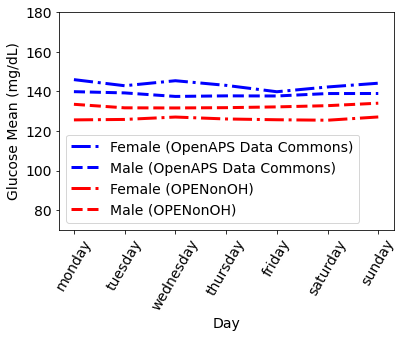

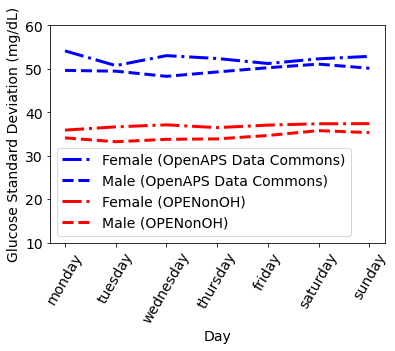

,mean,data,days,std,Day_id
7,145.991885,stats_f.csv,monday,54.142251,0
6,139.903664,stats_m.csv,monday,49.648345,0
9,142.907360,stats_f.csv,tuesday,50.759602,1
5,139.275358,stats_m.csv,tuesday,49.476195,1
13,145.437042,stats_f.csv,wednesday,53.050468,2
1,137.489728,stats_m.csv,wednesday,48.286131,2
10,143.083965,stats_f.csv,thursday,52.389695,3
2,137.783317,stats_m.csv,thursday,49.298467,3
12,139.867508,stats_f.csv,friday,51.236093,4
3,137.716681,stats_m.csv,friday,50.270050,4


In [44]:
path = r'/home/reinhold/Daten/Paper_Datasets_Nov2022/results/daily/'  # specify data path

extension = 'csv'

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]
files_unstrip_IDs = [i.split('_', 1)[1] for i in files]
days = [i.split('_', 1)[0] for i in files]

i = 0
mean = []
std = []

for f in files:
    p = os.path.join(path, f)

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")

    mean.append(df['mean'].mean())
    std.append(df['std'].mean())

    i = i + 1

stats = pd.DataFrame({
    'days': days,
    'mean': mean,
    'std': std,
    'data': files_unstrip_IDs,
})

all_stat = pd.concat([stats], axis=1)

all_stat.sort_values('data', inplace=True, ascending=False)
all_stat.reset_index(drop=True, inplace=True)

#print(all_stat)

statt = all_stat[['mean', 'data', 'days', 'std']].sort_values('data')

sorter = [
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday',
    'sunday'
]
sorterIndex = dict(zip(sorter, range(len(sorter))))

statt['Day_id'] = statt.index
statt['Day_id'] = statt['days'].map(sorterIndex)

statt.sort_values('Day_id', inplace=True)

da_f = statt[statt['data'] == 'stats_f.csv']
da_m = statt[statt['data'] == 'stats_m.csv']

## Plotting data

# Designate a figure size and font size
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})

plt.ylim(70, 180)

ax = plt.plot(da_f['days'],
              da_f['mean'],
              color='blue',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(da_m['days'],
              da_m['mean'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["DoW"]["Female"]['DoW_str'],
              df3["DoW"]["Female"]['sgv_mean'],
              color='red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["DoW"]["Male"]['DoW_str'],
              df3["DoW"]["Male"]['sgv_mean'],
              color='red',
              linestyle='--',
              linewidth=3)

plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPENonOH)', 'Male (OPENonOH)'])
plt.xlabel('Day')
plt.ylabel('Glucose Mean (mg/dL)')
plt.xticks(rotation=60)
plt.show()

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})
plt.ylim(10, 60)
ax = plt.plot(da_f['days'],
              da_f['std'],
              color='blue',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(da_m['days'],
              da_m['std'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["DoW"]["Female"]['DoW_str'],
              df3["DoW"]["Female"]['sgv_std'],
              color='red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["DoW"]["Male"]['DoW_str'],
              df3["DoW"]["Male"]['sgv_std'],
              color='red',
              linestyle='--',
              linewidth=3)

plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPENonOH)', 'Male (OPENonOH)'])
plt.xlabel('Day')
plt.ylabel('Glucose Standard Deviation (mg/dL)')
plt.xticks(rotation=60)
plt.show()
statt

# Plot hourly average statistics

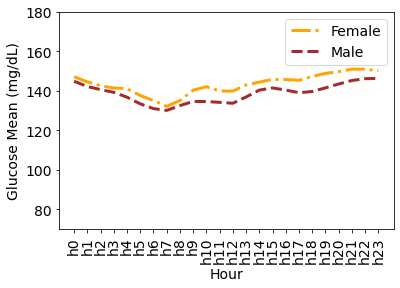

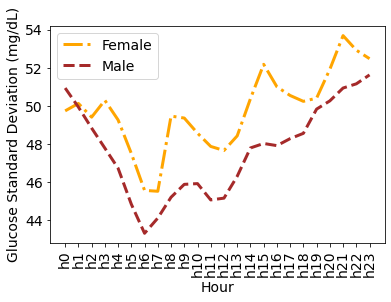

,hours,mean_m,std_m,mean_f,std_f,hour_id
0,h0,144.852227,50.932793,147.095983,49.733986,0
11,h1,142.171011,49.933113,144.552438,50.124410,1
16,h2,140.616969,48.828701,142.582262,49.404791,2
17,h3,139.231543,47.776770,141.429448,50.288675,3
18,h4,136.781015,46.717217,141.074636,49.256849,4
19,h5,133.424248,44.829261,137.647481,47.497692,5
20,h6,130.993650,43.303572,135.052980,45.556819,6
21,h7,130.090866,44.103694,132.127052,45.511040,7
22,h8,132.510147,45.196226,135.067054,49.458582,8
23,h9,134.627697,45.873938,140.293890,49.357249,9


In [15]:
path = r''  # specify data path

extension = 'csv'

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]
files_unstrip_IDs = [i.split('_', 1)[1] for i in files]
hours = [i.split('_', 1)[0] for i in files]

i = 0
mean_m = []
std_m = []

mean_f = []
std_f = []

for f in files:
    p = os.path.join(path, f)

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")

    mean_m.append(df.loc[df['gender'] == 'Male', 'mean'].mean())
    std_m.append(df.loc[df['gender'] == 'Male', 'std'].mean())

    mean_f.append(df.loc[df['gender'] == 'Female', 'mean'].mean())
    std_f.append(df.loc[df['gender'] == 'Female', 'std'].mean())

    i = i + 1

stats = pd.DataFrame({
    'hours': hours,
    'mean_m': mean_m,
    'std_m': std_m,
    'mean_f': mean_f,
    'std_f': std_f
})

statt = pd.concat([stats], axis=1).sort_values('hours')

#all_stat.sort_values('data',inplace=True, ascending=False)
#all_stat.reset_index(drop=True, inplace=True)

#print(all_stat)

sorter = [
    'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11',
    'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21',
    'h22', 'h23'
]

sorterIndex = dict(zip(sorter, range(len(sorter))))

statt['hour_id'] = statt.index
statt['hour_id'] = statt['hours'].map(sorterIndex)

statt.sort_values('hour_id', inplace=True)

## Plotting data

# Designate a figure size and font size
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})
plt.ylim(70, 180)
ax = plt.plot(statt['hours'],
              statt['mean_f'],
              color='orange',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(statt['hours'],
              statt['mean_m'],
              color='brown',
              linestyle='--',
              linewidth=3)

plt.legend(['Female', 'Male'])
plt.xlabel('Hour')
plt.ylabel('Glucose Mean (mg/dL)')
plt.xticks(rotation=90)
plt.show()

##

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})

ax = plt.plot(statt['hours'],
              statt['std_f'],
              color='orange',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(statt['hours'],
              statt['std_m'],
              color='brown',
              linestyle='--',
              linewidth=3)

plt.legend(['Female', 'Male'])
plt.xlabel('Hour')
plt.ylabel('Glucose Standard Deviation (mg/dL)')
plt.xticks(rotation=90)
plt.show()
statt

# Average Statistics based on Monthly Breakdown 

In [88]:
path = r'/home/reinhold/Daten/Paper_Datasets_Nov2022/results/monthly/'  # specify data path

extension = 'csv'

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]
files_unstrip_IDs = [i.split('_', 1)[1] for i in files]
months = [i.split('_', 1)[0] for i in files]

i = 0
mean_m = []
std_m = []

mean_f = []
std_f = []

for f in files:
    p = os.path.join(path, f)

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")

    mean_m.append(df.loc[df['gender'] == 'Male', 'mean'].mean())
    std_m.append(df.loc[df['gender'] == 'Male', 'std'].mean())

    mean_f.append(df.loc[df['gender'] == 'Female', 'mean'].mean())
    std_f.append(df.loc[df['gender'] == 'Female', 'std'].mean())

    i = i + 1

stats = pd.DataFrame({
    'months': months,
    'mean_m': mean_m,
    'std_m': std_m,
    'mean_f': mean_f,
    'std_f': std_f
})

statt = pd.concat([stats], axis=1).sort_values('months')

sorter = [
    'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'
]

sorterIndex = dict(zip(sorter, range(len(sorter))))

statt['month_id'] = statt.index
statt['month_id'] = statt['months'].map(sorterIndex)

statt.sort_values('month_id', inplace=True)

df3["month"]["Female"].sort_values('month', inplace=True)
df3["month"]["Female"]["month_id"] = df3["month"]["Female"]['month'].map(sorterIndex)
df3["month"]["Female"].sort_values('month_id', inplace=True)
df3["month"]["Male"].sort_values('month', inplace=True)
df3["month"]["Male"]["month_id"] = df3["month"]["Male"]['month'].map(sorterIndex)
df3["month"]["Male"].sort_values('month_id', inplace=True)

## Plotting data

# Designate a figure size and font size
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})

plt.ylim(70, 180)

ax = plt.plot(statt['months'],
              statt['mean_f'],
              color='blue',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(statt['months'],
              statt['mean_m'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["month"]["Female"]['month'],
              df3["month"]["Female"]['sgv_mean'],
              color='red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["month"]["Male"]['month'],
              df3["month"]["Male"]['sgv_mean'],
              color='red',
              linestyle='--',
              linewidth=3)

plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPENonOH)', 'Male (OPENonOH)'])
plt.xlabel('Month')
plt.ylabel('Glucose Mean (mg/dL)')
plt.xticks(rotation=90)
plt.show()

##

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})
plt.ylim(10, 60)

ax = plt.plot(statt['months'],
              statt['std_f'],
              color='blue',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(statt['months'],
              statt['std_m'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["month"]["Female"]['month'],
              df3["month"]["Female"]['sgv_std'],
              color='red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["month"]["Male"]['month'],
              df3["month"]["Male"]['sgv_std'],
              color='red',
              linestyle='--',
              linewidth=3)

plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPENonOH)', 'Male (OPENonOH)'])
plt.xlabel('Month')
plt.ylabel('Glucose Standard Deviation (mg/dL)')
plt.xticks(rotation=90)
plt.show()

statt

ValueError: 'month' is both an index level and a column label, which is ambiguous.

# Average Statistics based on Date of Month Breakdown 

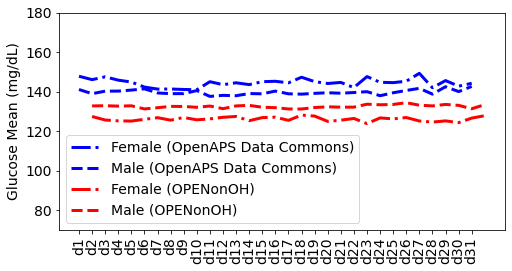

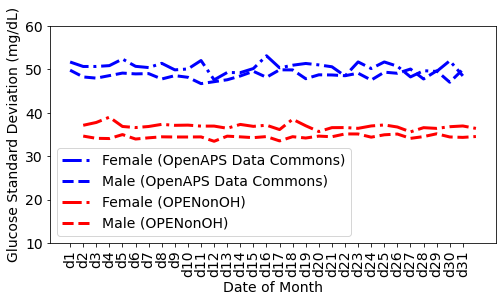

,date,mean_m,std_m,mean_f,std_f,date_id
29,d1,141.097574,49.747564,147.808991,51.632453,0
0,d2,138.977394,48.195104,146.090871,50.600743,1
20,d3,140.264595,47.922889,147.507017,50.604757,2
2,d4,140.289946,48.499641,145.831012,50.799595,3
7,d5,140.802682,49.082583,144.879594,52.316367,4
3,d6,141.449427,48.898424,142.330616,50.635910,5
11,d7,139.353886,48.964342,141.314241,50.351607,6
9,d8,138.998952,47.724005,141.349308,51.331425,7
27,d9,139.021585,48.495353,141.116513,49.822438,8
15,d10,140.549584,48.111766,140.987706,50.032479,9


In [55]:
path = r'/home/reinhold/Daten/Paper_Datasets_Nov2022/results/dateofmonth/'  # specify data path

extension = 'csv'

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]
files_unstrip_IDs = [i.split('_', 1)[1] for i in files]
date = [i.split('_', 1)[0] for i in files]

i = 0
mean_m = []
std_m = []

mean_f = []
std_f = []

for f in files:
    p = os.path.join(path, f)

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")

    mean_m.append(df.loc[df['gender'] == 'Male', 'mean'].mean())
    std_m.append(df.loc[df['gender'] == 'Male', 'std'].mean())

    mean_f.append(df.loc[df['gender'] == 'Female', 'mean'].mean())
    std_f.append(df.loc[df['gender'] == 'Female', 'std'].mean())

    i = i + 1

stats = pd.DataFrame({
    'date': date,
    'mean_m': mean_m,
    'std_m': std_m,
    'mean_f': mean_f,
    'std_f': std_f
})

statt = pd.concat([stats], axis=1).sort_values('date')

#all_stat.sort_values('data',inplace=True, ascending=False)
#all_stat.reset_index(drop=True, inplace=True)

#print(all_stat)

sorter = [
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12',
    'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22',
    'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31'
]

sorterIndex = dict(zip(sorter, range(len(sorter))))

statt['date_id'] = statt.index
statt['date_id'] = statt['date'].map(sorterIndex)

statt.sort_values('date_id', inplace=True)

## Plotting data

# Designate a figure size and font size
plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 14})

plt.ylim(70, 180)

ax = plt.plot(statt['date'],
              statt['mean_f'],
              color='blue',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(statt['date'],
              statt['mean_m'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["day"]["Female"]['day'],
              df3["day"]["Female"]['sgv_mean'],
              color='red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["day"]["Male"]['day'],
              df3["day"]["Male"]['sgv_mean'],
              color='red',
              linestyle='--',
              linewidth=3)

plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPENonOH)', 'Male (OPENonOH)'])
plt.ylabel('Glucose Mean (mg/dL)')
plt.xticks(rotation=90)
plt.show()

##

plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 14})
plt.ylim(10, 60)
ax = plt.plot(statt['date'],
              statt['std_f'],
              color='blue',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(statt['date'],
              statt['std_m'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["day"]["Female"]['day'],
              df3["day"]["Female"]['sgv_std'],
              color='red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["day"]["Male"]['day'],
              df3["day"]["Male"]['sgv_std'],
              color='red',
              linestyle='--',
              linewidth=3)

plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPENonOH)', 'Male (OPENonOH)'])
plt.xlabel('Date of Month')
plt.ylabel('Glucose Standard Deviation (mg/dL)')
plt.xticks(rotation=90)
plt.show()

statt